# Analyse ROMY Events

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees import sixdegrees

## Configurations

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2024-12-05 18:44:21",  # Start time
    'tend': "2024-12-05 20:44:21",  # End time

    # event
    'origin_time': "2024-12-05 18:44:26",
    'magnitude': 7.0,

    # SEED identifiers
    'seed': "XX.RLAS..",     # seed ID of output stream
    'rot_seed': ["BW.RLAS..BJZ"], # Rotation sensor seed ID
    'tra_seed': ["GR.WET..BHZ", "GR.WET..BHN", "GR.WET..BHE"],  # Translation sensor seed ID
    
    # rotate to ZNE
    'rotate_to_zne': False,

    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # FDSN client
    # 'fdsn_client_rot': "LMU",  # "IRIS",
    # 'fdsn_client_tra': "BGR",  # "IRIS",

    # Path to local mseed file
    'path_to_mseed_file': "./data/G_eventM7.0.mseed",  # "./data/eventM62_6c.mseed",

    # Path to SDS for rotation and translation data
    # 'path_to_sds_rot': "/home/andbro/freenas/temp_archive/",    # SDS path for rotation data
    # 'path_to_sds_tra': "/home/andbro/bay200/mseed_online/archive/",  # SDS path for translation data

    # Path to inventory of rotation and translation sensor
    # 'path_to_inv_rot': "/home/andbro/kilauea-data/stationxml_ringlaser/station_BW_RLAS.xml",  # Rotation station inventory
    # 'path_to_inv_tra': "/home/andbro/kilauea-data/stationxml_ringlaser/station_GR_WET.xml",  # Translation station inventory
    
    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "G_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'time_win_sec': 30,          # Window length in seconds
    'time_win_sec_overlap': 15,  # Window overlap in seconds
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [4]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [5]:
sd.load_data(config['tbeg'], config['tend'])

1 Trace(s) in Stream:
XX.RLAS..BHZ | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
2 Trace(s) in Stream:
XX.RLAS..BHZ | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
XX.RLAS..BHN | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
3 Trace(s) in Stream:
XX.RLAS..BHZ | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
XX.RLAS..BHN | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
XX.RLAS..BHE | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
1 Trace(s) in Stream:
XX.RLAS..BJZ | 2024-12-05T18:44:19.981749Z - 2024-12-05T20:44:21.981749Z | 20.0 Hz, 144041 samples


Get key information about the earthquake

In [6]:
ev = sd.get_event_info(origin_time=config['origin_time'],
                       base_catalog="USGS",
                       magnitude=config['magnitude'])

Error getting event information from USGS:
float() argument must be a string or a real number, not 'NoneType'


Ensure that all traces of stream have the same sample size

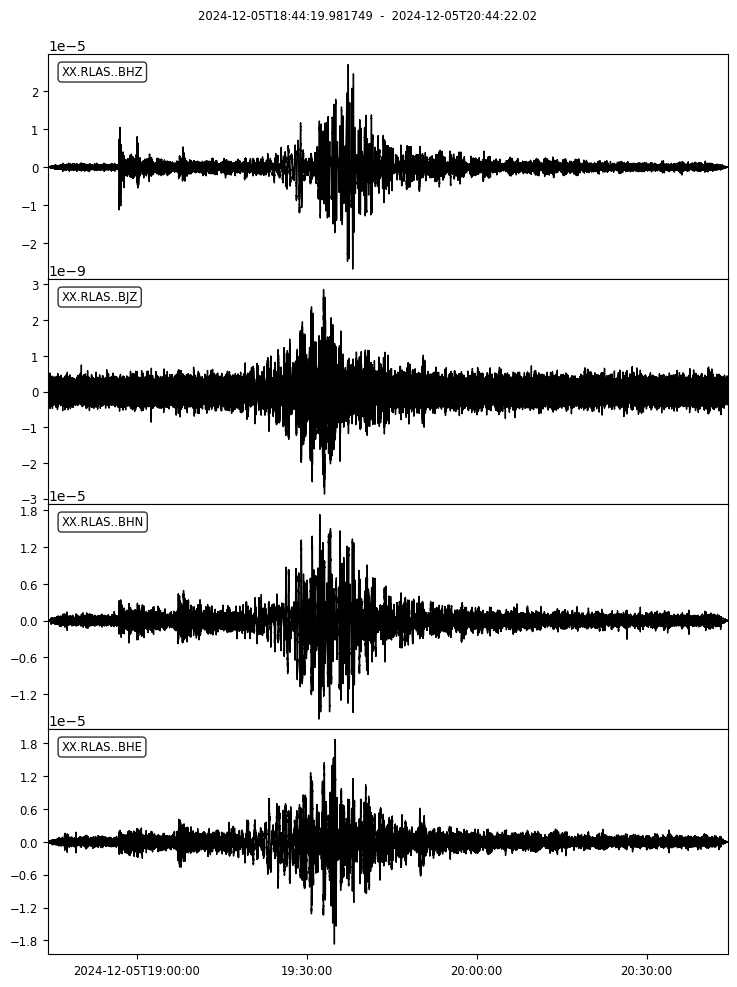

In [7]:
sd.st.plot(equal_scale=False);

In [8]:
sd.trim_stream(set_common=True, set_interpolate=False)

### Write data to file or SDS system

In [9]:
# write to mseed file
# sd.st.write(f"./data/G_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

In [10]:
sd.get_theoretical_arrival(phase='p')

No event information available. Run get_event_info first.


### Wavelet Comparsion

In [11]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Rotation"] = sd.compute_cwt(
            rot_data.times(), rot_data.data, rot_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Translation"] = sd.compute_cwt(
            acc_data.times(), acc_data.data, acc_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for ranslation")


No N data for rotation
No E data for rotation


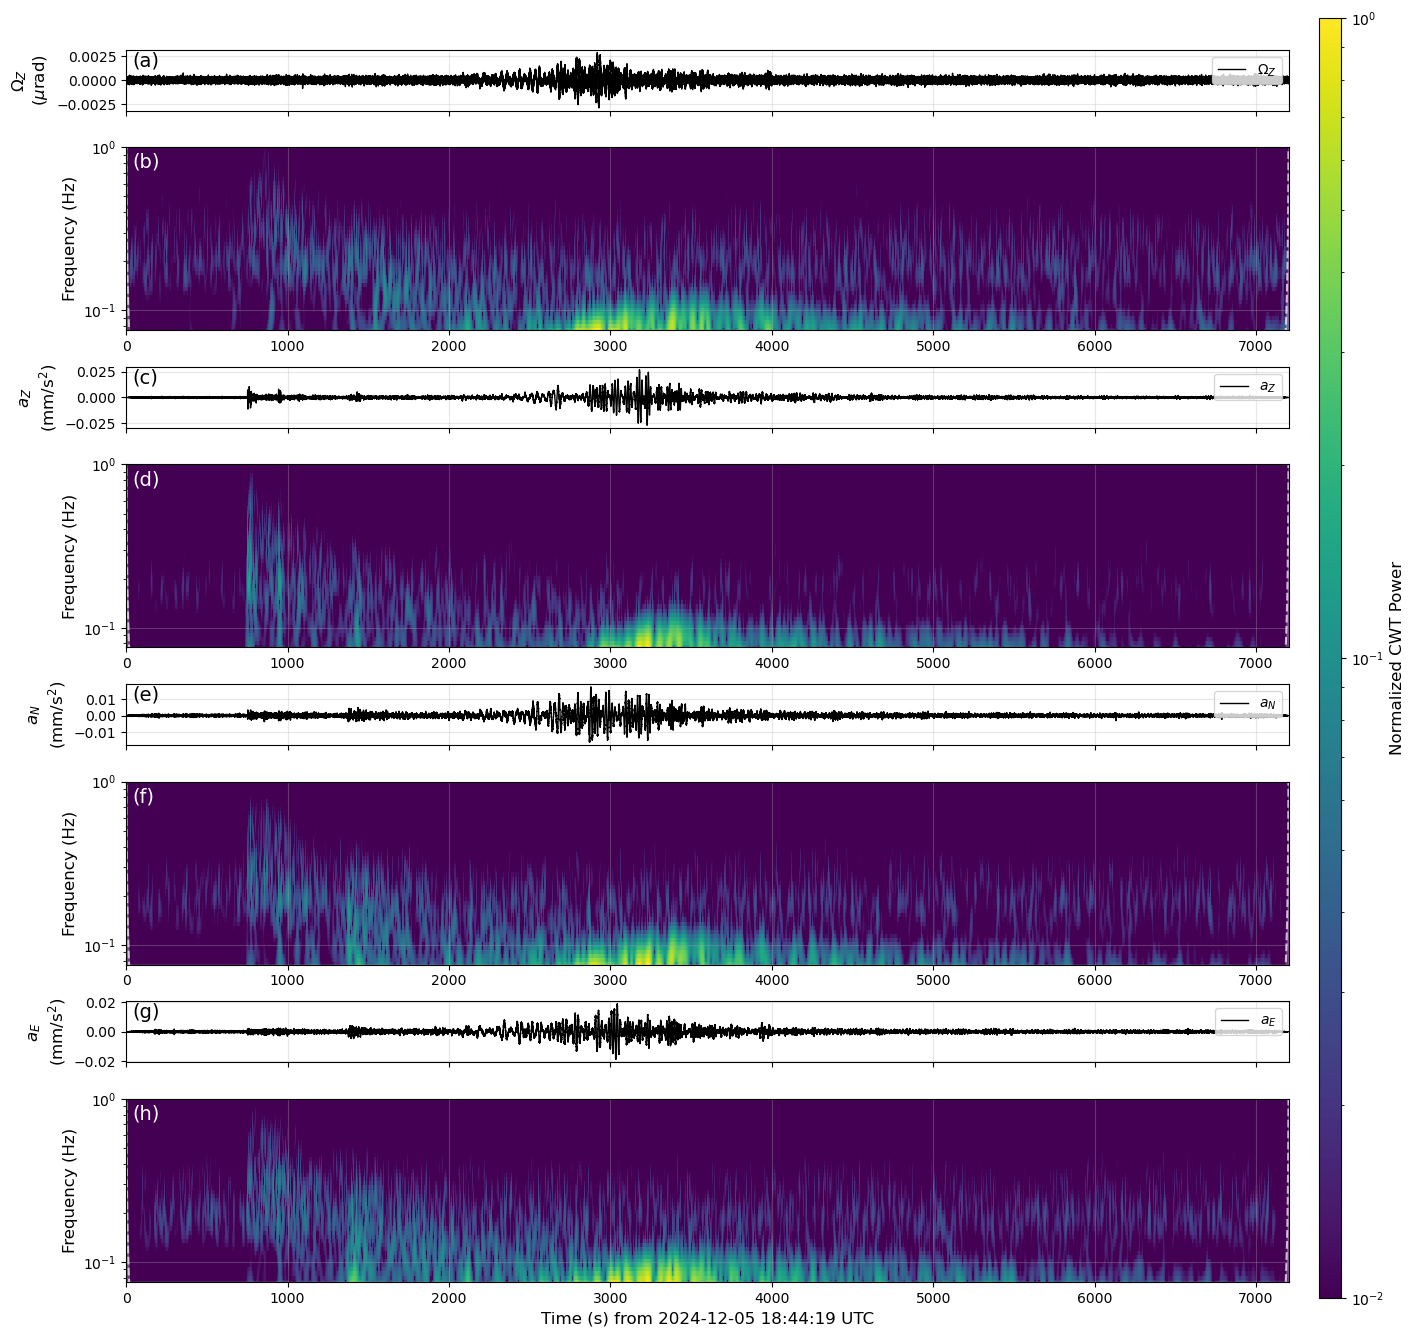

In [12]:
# Then plot all components
fig = sixdegrees.plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=1
)

del fig

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [13]:
sd.filter_data(fmin=0.01, fmax=0.1, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [14]:
sd.polarity_stream(pol_dict={"HZ": 1, "JZ": 1}, raw=True)

let's compare the waveforms of the rotation (red) and translational (black) components 

In [15]:
fig = sd.plot_waveform_cc(rot0=sd.get_stream("rotation"),
                        acc0=sd.get_stream("translation"),
                        baz=ev['backazimuth'],
                        distance=ev['distance_km'],
                        fmin=sd.fmin, fmax=sd.fmax, 
                        twin_sec=50, twin_overlap=0.5,
                        wave_type='love'
                        )

KeyError: 'backazimuth'

In [16]:
# fig = sd.plot_spectra_comparison_fill(rot=sd.get_stream("rotation"), 
#                                       acc=sd.get_stream("translation"),
#                                       fmin=0.09, fmax=0.6,
#                                       ylog=False, xlog=False, fill=True
#                                       )

### Backazimuth Estimate

In [ ]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=100,
    baz_win_sec_overlap=0.5,
    out=True
)



using love waves for backazimuth estimation ...


max = 310, mean = 288.0, std = 52.01718064803


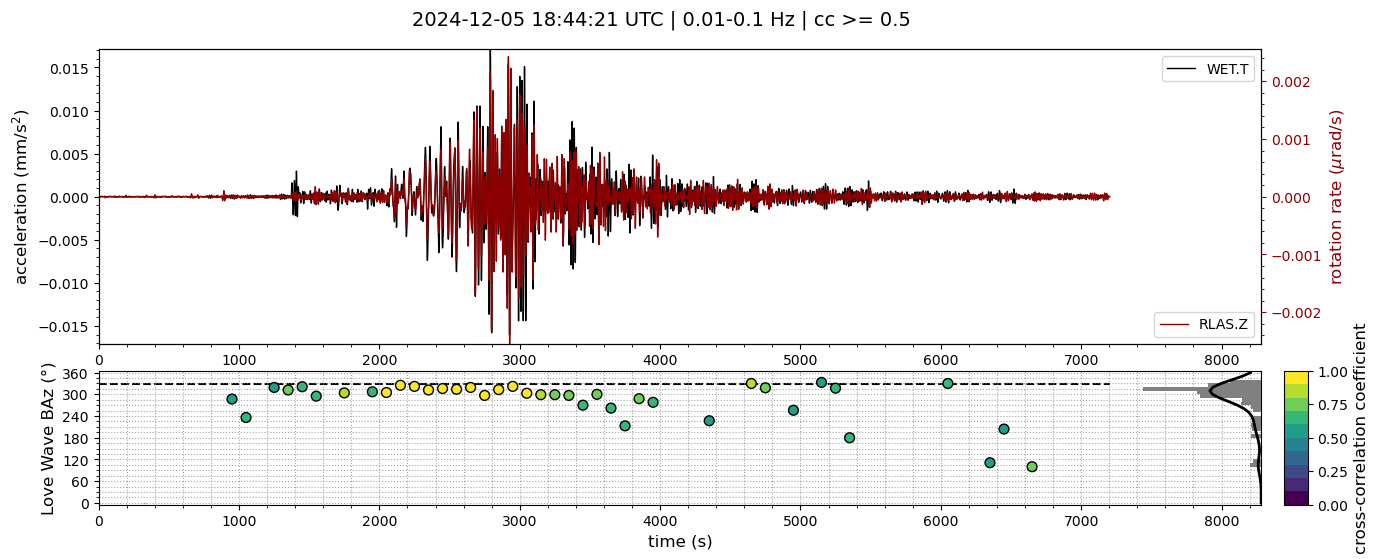

In [ ]:
# plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)

### Analyse phase velocities

In [19]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=50.0,
    overlap=0.5,
    cc_threshold=0.,
    method='odr',
    baz=ev['backazimuth']  # optional
)


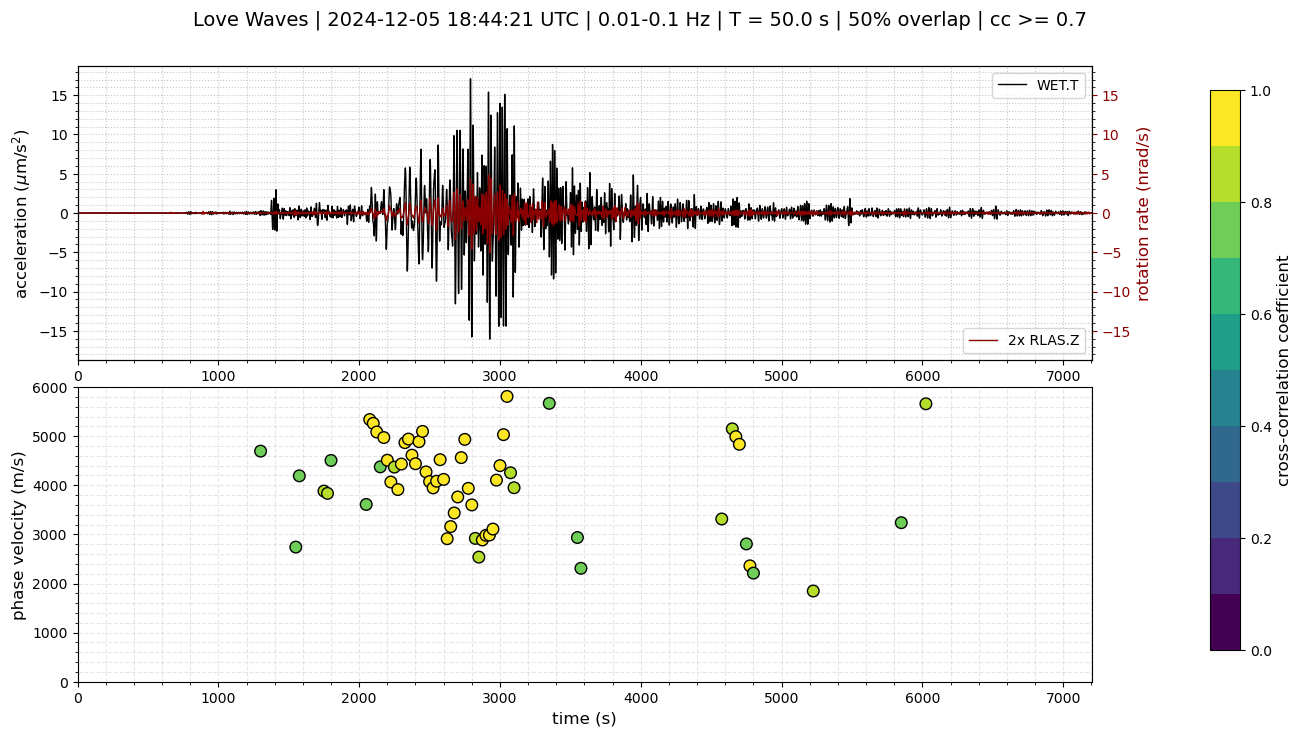

In [20]:
# Plot results
fig = sd.plot_velocities(
    velocity_results=love_velocities,
    vmax=6000,  # optional
    minors=True, # optional
    cc_threshold=0.7

)
